**CII4Q3 Visi Komputer**

---



#Exercise 3: Image Augmentation

---
Prapemrosesan pada citra untuk membantu meningkatkan kinerja klasifikasi



1.   Pelajari dengan baik code berikut
2.   Ubah pada bagian **ImageGeneration** agar akurasi dapat mencapai **minimal 88%**



##### Copyright 2019 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Let's start with a model that's very effective at learning Cats v Dogs.

In this model, we use 4 convolutional layers with 32, 64, 128 and 128 convolutions respectively.

Also, this will train for 100 epochs, because I want to plot the graph of loss and accuracy.

In [4]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

##### Image preprocessing: only rescale the image #####
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 55s - loss: 0.7234 - accuracy: 0.5215 - val_loss: 0.6915 - val_accuracy: 0.5000 - 55s/epoch - 546ms/step
Epoch 2/100
100/100 - 60s - loss: 0.6925 - accuracy: 0.5350 - val_loss: 0.6570 - val_accuracy: 0.5980 - 60s/epoch - 597ms/step
Epoch 3/100
100/100 - 54s - loss: 0.6586 - accuracy: 0.6130 - val_loss: 0.6524 - val_accuracy: 0.6220 - 54s/epoch - 542ms/step
Epoch 4/100
100/100 - 52s - loss: 0.6183 - accuracy: 0.6570 - val_loss: 0.5952 - val_accuracy: 0.6970 - 52s/epoch - 524ms/step
Epoch 5/100
100/100 - 46s - loss: 0.5992 - accuracy: 0.6880 - val_loss: 0.5895 - val_accuracy: 0.6950 - 46s/epoch - 457ms/step
Epoch 6/100
100/100 - 47s - loss: 0.5550 - accuracy: 0.7185 - val_loss: 0.5920 - val_accuracy: 0.6970 - 47s/epoch - 466ms/step
Epoch 7/100
100/100 - 45s - loss: 0.5268 - accuracy: 0.7275 - val_loss: 0.5665 - val_accuracy: 0.7000 - 45s/epoch - 451ms/step
Epoch 8/100
100/100 - 46s -

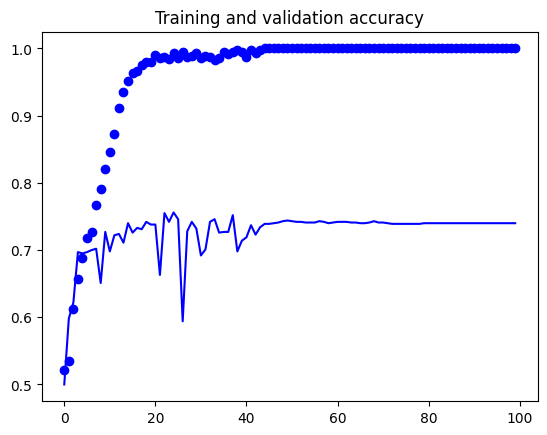

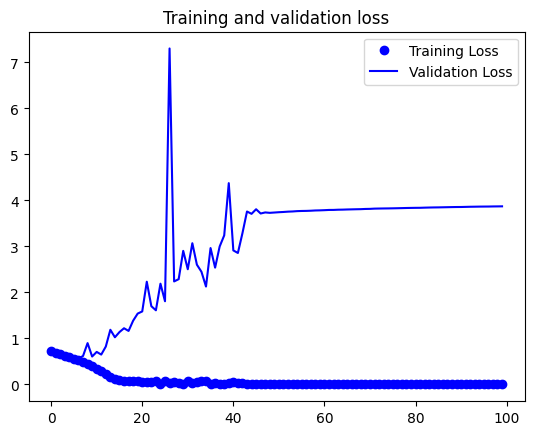

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The Training Accuracy is close to 100%, and the validation accuracy is in the 70%-80% range. This is a great example of overfitting -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't. Let's see if we can do better to avoid overfitting -- and one simple method is to augment the images a bit. If you think about it, most pictures of a cat are very similar -- the ears are at the top, then the eyes, then the mouth etc. Things like the distance between the eyes and ears will always be quite similar too.

What if we tweak with the images to change this up a bit -- rotate the image, squash it, etc.  That's what image augementation is all about. And there's an API that makes it easy...

Now take a look at the ImageGenerator. There are properties on it that you can use to augment the image.

```
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```
These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* shear_range is for randomly applying shearing transformations.
* zoom_range is for randomly zooming inside pictures.
* horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


Here's some code where we've added Image Augmentation. Run it to see the impact.


In [6]:
 
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 49s - loss: 0.7216 - accuracy: 0.5250 - val_loss: 0.6922 - val_accuracy: 0.5000 - 49s/epoch - 494ms/step
Epoch 2/100
100/100 - 48s - loss: 0.6958 - accuracy: 0.5285 - val_loss: 0.6791 - val_accuracy: 0.5800 - 48s/epoch - 483ms/step
Epoch 3/100
100/100 - 49s - loss: 0.6886 - accuracy: 0.5550 - val_loss: 0.6609 - val_accuracy: 0.6200 - 49s/epoch - 486ms/step
Epoch 4/100
100/100 - 47s - loss: 0.6788 - accuracy: 0.5795 - val_loss: 0.6571 - val_accuracy: 0.6360 - 47s/epoch - 474ms/step
Epoch 5/100
100/100 - 46s - loss: 0.6665 - accuracy: 0.6160 - val_loss: 0.6076 - val_accuracy: 0.6770 - 46s/epoch - 463ms/step
Epoch 6/100
100/100 - 47s - loss: 0.6523 - accuracy: 0.6260 - val_loss: 0.6076 - val_accuracy: 0.6720 - 47s/epoch - 469ms/step
Epoch 7/100
100/100 - 48s - loss: 0.6403 - accuracy: 0.6395 - val_loss: 0.5943 - val_accuracy: 0.6640 - 48s/epoch - 478ms/step
Epoch 8/100
100/100 - 47s -

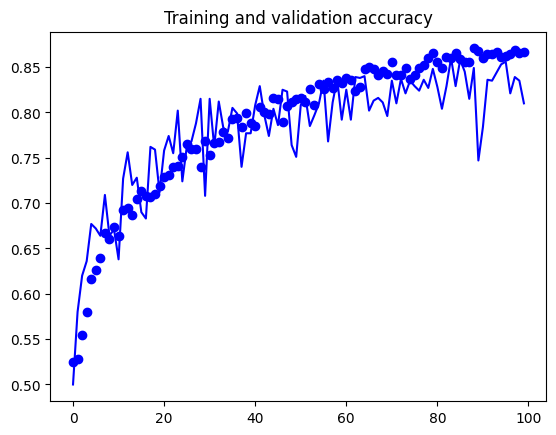

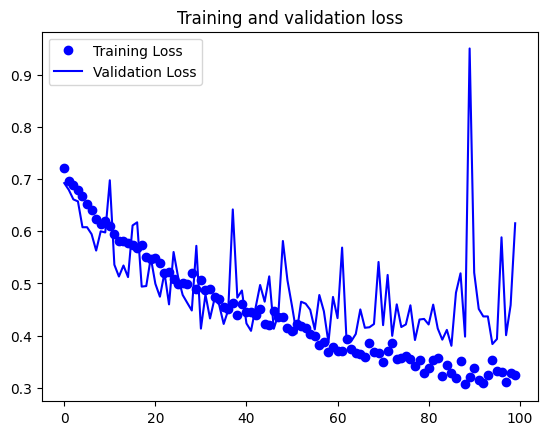

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.RMSprop(lr=1e-4), #menambah tf.optimizers untuk optimasi
              metrics=['accuracy'])

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

# Evaluasi model dan akurasi
_, acc = model.evaluate(validation_generator, verbose=0)
print('Accuracy: %.2f%%' % (acc * 100))

'wget' is not recognized as an internal or external command,
operable program or batch file.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 - 51s - loss: 0.7422 - accuracy: 0.5140 - val_loss: 0.6939 - val_accuracy: 0.5000 - 51s/epoch - 505ms/step
Epoch 2/100
100/100 - 53s - loss: 0.6995 - accuracy: 0.5105 - val_loss: 0.6897 - val_accuracy: 0.6230 - 53s/epoch - 526ms/step
Epoch 3/100
100/100 - 50s - loss: 0.6915 - accuracy: 0.5300 - val_loss: 0.6830 - val_accuracy: 0.5780 - 50s/epoch - 495ms/step
Epoch 4/100
100/100 - 50s - loss: 0.6803 - accuracy: 0.5730 - val_loss: 0.6986 - val_accuracy: 0.5510 - 50s/epoch - 499ms/step
Epoch 5/100
100/100 - 50s - loss: 0.6640 - accuracy: 0.6105 - val_loss: 0.6337 - val_accuracy: 0.6570 - 50s/epoch - 501ms/step
Epoch 6/100
100/100 - 51s - loss: 0.6412 - accuracy: 0.6280 - val_loss: 0.6336 - val_accuracy: 0.6250 - 51s/epoch - 511ms/step
Epoch 7/100
100/100 - 50s - loss: 0.6378 - accuracy: 0.6310 - val_loss: 0.6020 - val_accuracy: 0.6760 - 50s/epoch - 497ms/step
Epoch 8/100
100/100 - 44s -

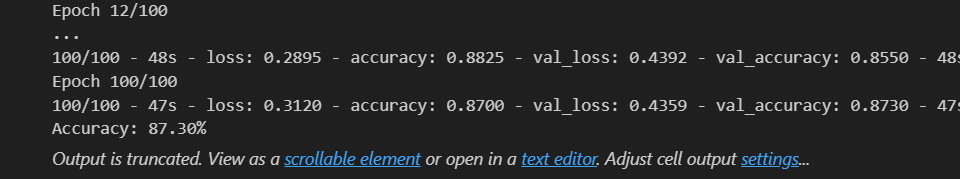

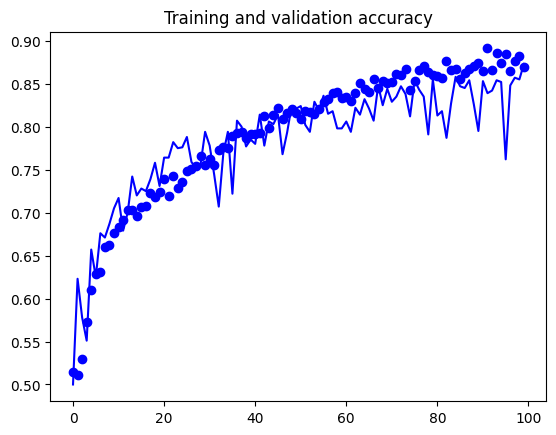

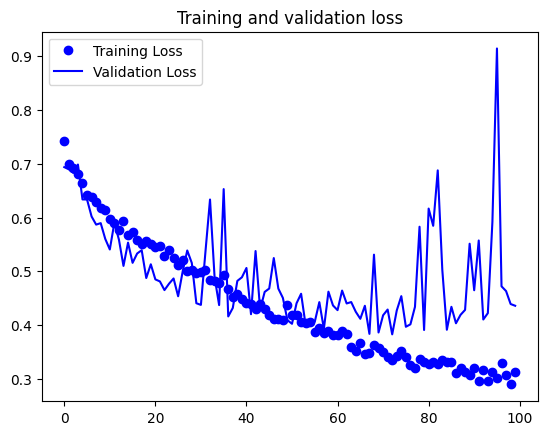

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Menggunakan ImageDataGenerator dapat meningkatkan akurasi dibanding tidak menggunakan ImageDataGenerator